<a href="https://colab.research.google.com/github/NayeonKimdev/computer-vision/blob/main/CNN_Filter_Learning_Principles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Filter Learning Principles and Detailed Analysis

In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
import torch.nn.functional as F

=== How CNN Filters Learn Different Features ===
=== 1. Filter Initialization State ===
Filters are randomly initialized (Xavier or He initialization)
Filter shape: torch.Size([4, 1, 3, 3])
Each filter size: 3x3
Total of 4 different filters


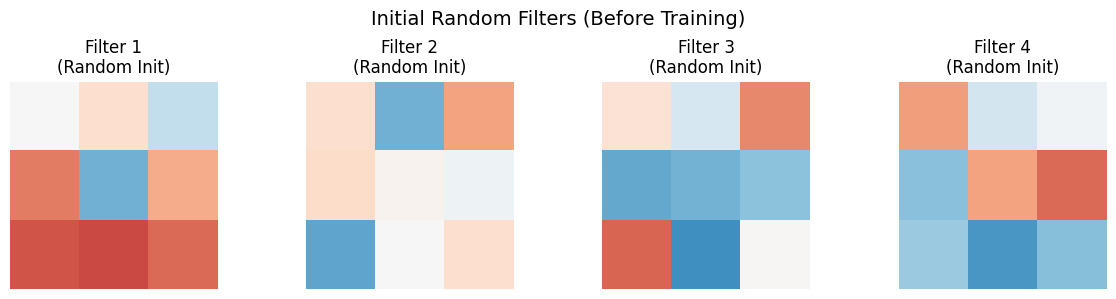

In [9]:
print("=== How CNN Filters Learn Different Features ===")

# 1. Filter initialization and learning process visualization
class SimpleConvLayer(nn.Module):
    """Single Conv layer to observe filter learning process"""
    def __init__(self, in_channels=1, out_channels=4):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        return self.conv(x)

# Create model
model = SimpleConvLayer(in_channels=1, out_channels=4)

print("=== 1. Filter Initialization State ===")
print("Filters are randomly initialized (Xavier or He initialization)")

# Check initial filter weights
initial_weights = model.conv.weight.data.clone()
print(f"Filter shape: {initial_weights.shape}")  # [out_channels, in_channels, height, width]
print(f"Each filter size: 3x3")
print(f"Total of 4 different filters")

# Visualize initial filters
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
fig.suptitle('Initial Random Filters (Before Training)', fontsize=14)

for i in range(4):
    filter_weights = initial_weights[i, 0].numpy()  # [i-th filter, 0-th channel]
    axes[i].imshow(filter_weights, cmap='RdBu', vmin=-0.5, vmax=0.5)
    axes[i].set_title(f'Filter {i+1}\n(Random Init)')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [10]:
print("\n=== 2. How Filters Differentiate During Learning ===")
print("""
Core Principle: GRADIENT DESCENT + BACKPROPAGATION

1. Loss Function Calculation: Measure how much each filter's output contributes to the final answer
2. Gradient Computation: Different gradients calculated for each filter independently
3. Weight Updates: Each filter updates in different directions
4. Iteration: Repeat thousands/tens of thousands of times until filters specialize in different features

Why do filters learn differently?
- Different starting points due to random initialization
- Independent gradient calculation for each filter
- Different responses to various input patterns
""")


=== 2. How Filters Differentiate During Learning ===

Core Principle: GRADIENT DESCENT + BACKPROPAGATION

1. Loss Function Calculation: Measure how much each filter's output contributes to the final answer
2. Gradient Computation: Different gradients calculated for each filter independently
3. Weight Updates: Each filter updates in different directions
4. Iteration: Repeat thousands/tens of thousands of times until filters specialize in different features

Why do filters learn differently?
- Different starting points due to random initialization
- Independent gradient calculation for each filter
- Different responses to various input patterns



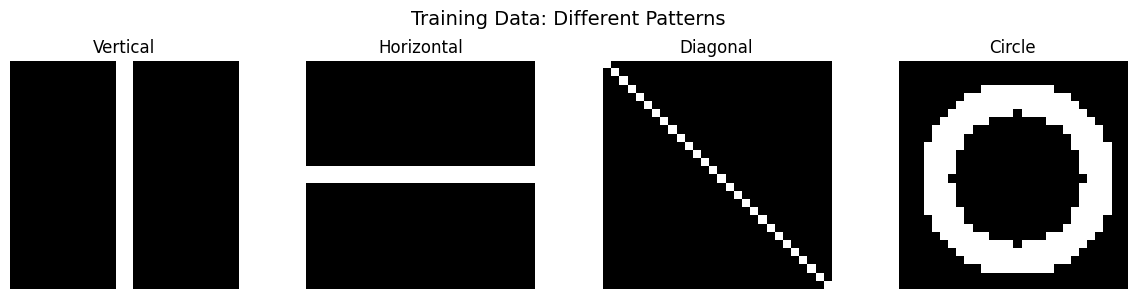

In [11]:
# 3. Actual filter learning simulation
def create_training_data():
    """Generate training data with various patterns"""
    data = []
    labels = []

    # Vertical line pattern
    vertical = np.zeros((28, 28))
    vertical[:, 13:15] = 1
    data.append(vertical)
    labels.append(0)

    # Horizontal line pattern
    horizontal = np.zeros((28, 28))
    horizontal[13:15, :] = 1
    data.append(horizontal)
    labels.append(1)

    # Diagonal line pattern
    diagonal = np.zeros((28, 28))
    for i in range(28):
        if i < 28:
            diagonal[i, i] = 1
    data.append(diagonal)
    labels.append(2)

    # Circle pattern
    circle = np.zeros((28, 28))
    center = 14
    for i in range(28):
        for j in range(28):
            if 8 < np.sqrt((i-center)**2 + (j-center)**2) < 12:
                circle[i, j] = 1
    data.append(circle)
    labels.append(3)

    return np.array(data), np.array(labels)

# Generate training data
train_data, train_labels = create_training_data()

# Data visualization
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
fig.suptitle('Training Data: Different Patterns', fontsize=14)
pattern_names = ['Vertical', 'Horizontal', 'Diagonal', 'Circle']

for i in range(4):
    axes[i].imshow(train_data[i], cmap='gray')
    axes[i].set_title(f'{pattern_names[i]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


=== 3. Analysis of Learned Filter Characteristics ===
Training simulation started...
Epoch 0: Loss = 1.3702
Epoch 20: Loss = 1.1764
Epoch 40: Loss = 1.0561
Epoch 60: Loss = 0.9683
Epoch 80: Loss = 0.8891
Training completed!


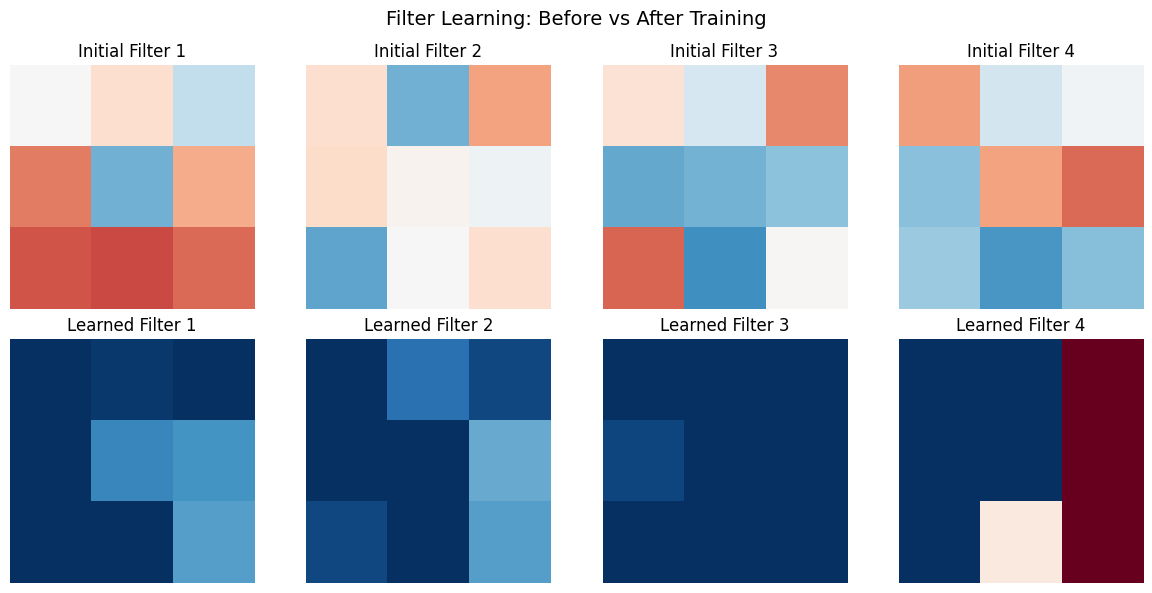

In [12]:
print("\n=== 3. Analysis of Learned Filter Characteristics ===")

# Define simple classification model
class PatternClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(4, 4)

    def forward(self, x):
        # Return both conv layer feature maps and final output
        conv_output = F.relu(self.conv1(x))
        pooled = self.pool(conv_output)
        flattened = pooled.view(pooled.size(0), -1)
        output = self.fc(flattened)
        return output, conv_output

# Model training (simulation)
classifier = PatternClassifier()
optimizer = Adam(classifier.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Convert training data to tensors
train_tensor = torch.FloatTensor(train_data).unsqueeze(1)  # [4, 1, 28, 28]
label_tensor = torch.LongTensor(train_labels)

print("Training simulation started...")
for epoch in range(100):  # Train for 100 epochs
    optimizer.zero_grad()

    outputs, conv_features = classifier(train_tensor)
    loss = criterion(outputs, label_tensor)

    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

print("Training completed!")

# Visualize learned filters
learned_weights = classifier.conv1.weight.data

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('Filter Learning: Before vs After Training', fontsize=14)

# Initial filters (top row)
for i in range(4):
    axes[0, i].imshow(initial_weights[i, 0].numpy(), cmap='RdBu', vmin=-0.5, vmax=0.5)
    axes[0, i].set_title(f'Initial Filter {i+1}')
    axes[0, i].axis('off')

# Learned filters (bottom row)
for i in range(4):
    axes[1, i].imshow(learned_weights[i, 0].numpy(), cmap='RdBu', vmin=-0.5, vmax=0.5)
    axes[1, i].set_title(f'Learned Filter {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


=== 4. Filter Response Analysis by Pattern ===


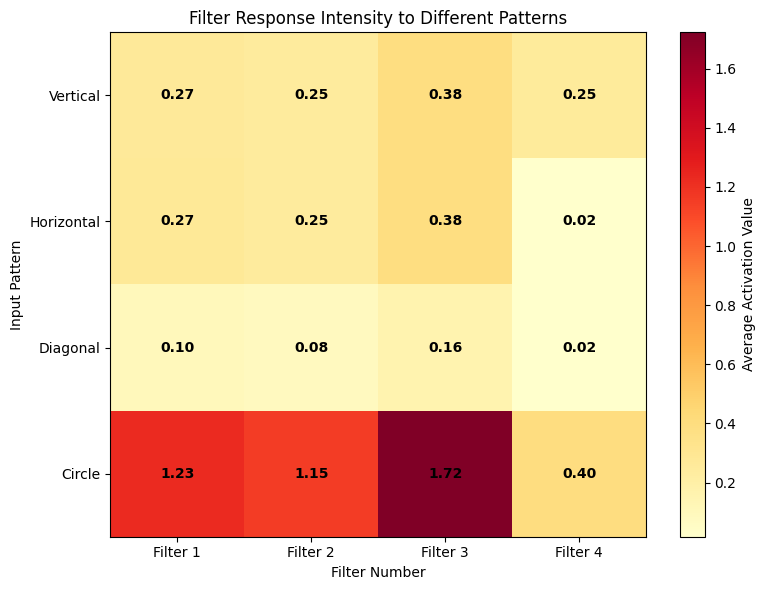


=== Conclusion: Why Filters Learn Different Features ===

1. Random Initialization: Each filter starts with different random values
2. Independent Gradients: Different gradients calculated for each filter
3. Loss Minimization: Filters naturally divide roles to minimize overall loss
4. Diverse Inputs: Various data patterns train filters differently

In Production Systems:
- Training with tens of millions of images
- Hundreds/thousands of filters learning simultaneously
- Each filter specializes in specific features (edges, textures, shapes, etc.)
- Deeper layers learn increasingly complex features


=== Additional Explanation: Real ImageNet-Trained Filters ===

In actual ImageNet-trained ResNet first layer filters:
- Filters 1-8: Vertical/horizontal edge detectors
- Filters 9-16: Diagonal edge detectors  
- Filters 17-24: Blob (shape) detectors
- Filters 25-32: Color transition detectors

This emerges naturally from training, not designed by humans!



In [13]:
# 4. Analyze which patterns each filter responds to
print("\n=== 4. Filter Response Analysis by Pattern ===")

with torch.no_grad():
    _, features = classifier(train_tensor)
    # features shape: [4, 4, 28, 28] = [batch, filters, height, width]

# Calculate average activation value for each filter on each pattern
filter_responses = []
for pattern_idx in range(4):
    pattern_responses = []
    for filter_idx in range(4):
        avg_response = features[pattern_idx, filter_idx].mean().item()
        pattern_responses.append(avg_response)
    filter_responses.append(pattern_responses)

filter_responses = np.array(filter_responses)

# Visualize as heatmap
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(filter_responses, cmap='YlOrRd', aspect='auto')

# Set axis labels
ax.set_xticks(range(4))
ax.set_yticks(range(4))
ax.set_xticklabels([f'Filter {i+1}' for i in range(4)])
ax.set_yticklabels(pattern_names)

# Display values
for i in range(4):
    for j in range(4):
        text = ax.text(j, i, f'{filter_responses[i, j]:.2f}',
                      ha="center", va="center", color="black", fontweight='bold')

ax.set_title('Filter Response Intensity to Different Patterns')
ax.set_xlabel('Filter Number')
ax.set_ylabel('Input Pattern')

plt.colorbar(im, ax=ax, label='Average Activation Value')
plt.tight_layout()
plt.show()

print("""
=== Conclusion: Why Filters Learn Different Features ===

1. Random Initialization: Each filter starts with different random values
2. Independent Gradients: Different gradients calculated for each filter
3. Loss Minimization: Filters naturally divide roles to minimize overall loss
4. Diverse Inputs: Various data patterns train filters differently

In Production Systems:
- Training with tens of millions of images
- Hundreds/thousands of filters learning simultaneously
- Each filter specializes in specific features (edges, textures, shapes, etc.)
- Deeper layers learn increasingly complex features
""")

print("\n=== Additional Explanation: Real ImageNet-Trained Filters ===")
print("""
In actual ImageNet-trained ResNet first layer filters:
- Filters 1-8: Vertical/horizontal edge detectors
- Filters 9-16: Diagonal edge detectors
- Filters 17-24: Blob (shape) detectors
- Filters 25-32: Color transition detectors

This emerges naturally from training, not designed by humans!
""")
